In [ ]:
from datasets import Dataset, Audio, DatasetDict,load_dataset ,concatenate_datasets
from torch.utils.data import DataLoader
import pandas as pd
import os

# Define paths
dataset_dir = "/home/hkngae/COMP5412/data/NoisySpeechDataset"
demand_dir = "/home/hkngae/COMP5412/data/local_datasets"
metadata_file = os.path.join(dataset_dir, "metadata.csv")
first_n = 400  # Number of examples to load for trial
demand_ds = load_dataset("JacobLinCool/VoiceBank-DEMAND-16k", cache_dir=demand_dir)

### Dataset demand_ds contains: ['train', 'test']
### Split 'train' contains 11572 examples
### Features: {'id': Value(dtype='string', id=None), 'clean': Audio(sampling_rate=16000, mono=True, decode=True, id=None), 'noisy': Audio(sampling_rate=16000, mono=True, decode=True, id=None)}
### Split 'test' contains 824 examples
### Features: {'id': Value(dtype='string', id=None), 'clean': Audio(sampling_rate=16000, mono=True, decode=True, id=None), 'noisy': Audio(sampling_rate=16000, mono=True, decode=True, id=None)}



# Check if metadata file exists and read its structure first
if os.path.exists(metadata_file):
    # Just peek at the first few rows to see the structure
    print("Metadata file columns:")
    print(pd.read_csv(metadata_file, nrows=1).columns.tolist())

    # Load only the first n examples from metadata for trial
    metadata_df = pd.read_csv(metadata_file).head(first_n)

    # Assuming columns like "noisy_file", "clean_file", "snr" exist
    # Adapt these column names to match your actual metadata structure
    dataset_dict = {
        "id": [str(i) for i in range(len(metadata_df))],
        "noisy": metadata_df["noisy_file"].tolist() if "noisy_file" in metadata_df.columns else [],
        "clean": metadata_df["clean_file"].tolist() if "clean_file" in metadata_df.columns else [],
        #"snr": metadata_df["snr"].tolist() if "snr" in metadata_df.columns else []
    }
    data_size=400
    
    # Create the dataset
    small_ds = Dataset.from_dict(dataset_dict)
    
    # Add audio loading functionality 
    if "noisy_file" in metadata_df.columns:
        small_ds = small_ds.cast_column("noisy", Audio(sampling_rate=16000))
    if "clean_file" in metadata_df.columns:
        small_ds = small_ds.cast_column("clean", Audio(sampling_rate=16000))
    
    # Inspect the small dataset
    print(f"Small dataset contains {len(small_ds)} examples")
    print(f"Features: {small_ds.features}")
    print(demand_ds["train"].features)
    #concat with demand_ds['train']
    combined_ds = DatasetDict({
        'custom': small_ds,
        'train': demand_ds['train'],
        'test': demand_ds['test']
        })
    full_ds = concatenate_datasets([combined_ds['custom'], combined_ds['train'], combined_ds['test']])

    print(f"\nCombined dataset size: {len(full_ds)} examples")
    print(f"Combined dataset features: {full_ds.features}")

    
else:
    print(f"Metadata file not found at {metadata_file}")
    print("Please check the path or create the metadata file.")

Metadata file columns:
['noisy_file', 'clean_file', 'noise_file', 'snr']
Small dataset contains 400 examples
Features: {'id': Value(dtype='string', id=None), 'noisy': Audio(sampling_rate=16000, mono=True, decode=True, id=None), 'clean': Audio(sampling_rate=16000, mono=True, decode=True, id=None)}
{'id': Value(dtype='string', id=None), 'clean': Audio(sampling_rate=16000, mono=True, decode=True, id=None), 'noisy': Audio(sampling_rate=16000, mono=True, decode=True, id=None)}


ValueError: Expected a list of Dataset objects or a list of IterableDataset objects, but element at position 1 is a dict.


--- Sample 1 (Index 865) ---
ID: p227_114
Noisy audio: 51200 samples, 3.20 seconds, 16000 Hz


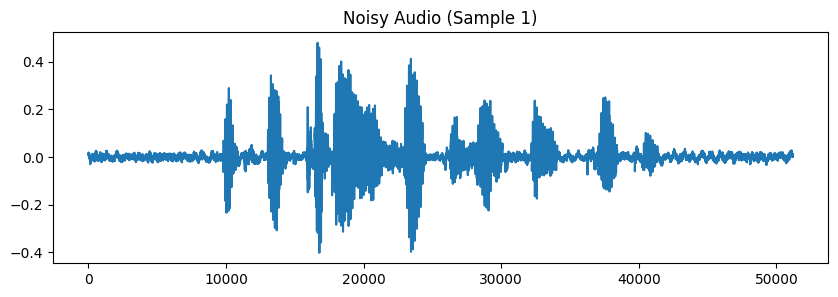

Noisy Audio:


Clean audio: 51200 samples, 3.20 seconds, 16000 Hz


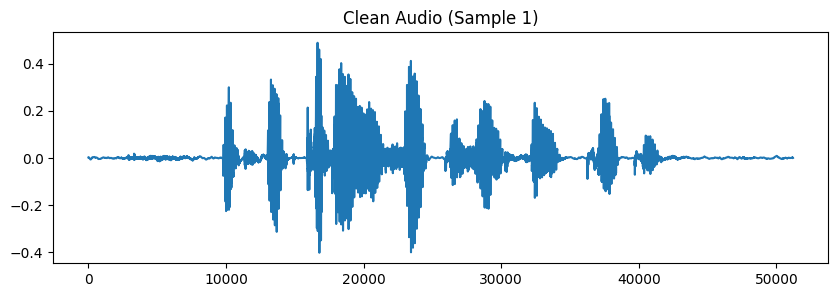

Clean Audio:



--- Sample 2 (Index 6430) ---
ID: p259_347
Noisy audio: 37994 samples, 2.37 seconds, 16000 Hz


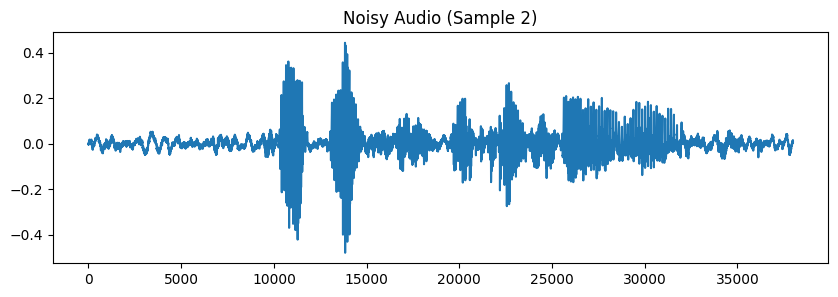

Noisy Audio:


Clean audio: 37994 samples, 2.37 seconds, 16000 Hz


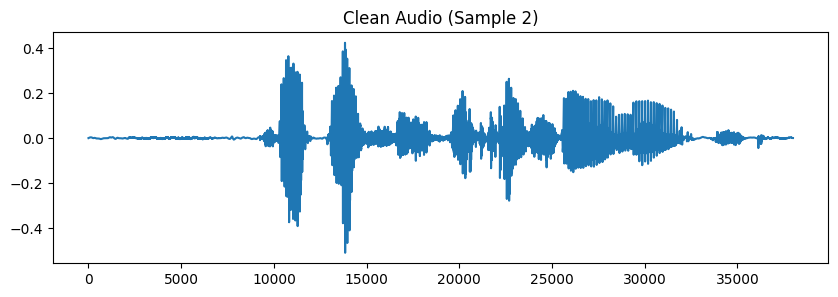

Clean Audio:



--- Sample 3 (Index 12224) ---
ID: p232_268
Noisy audio: 34198 samples, 2.14 seconds, 16000 Hz


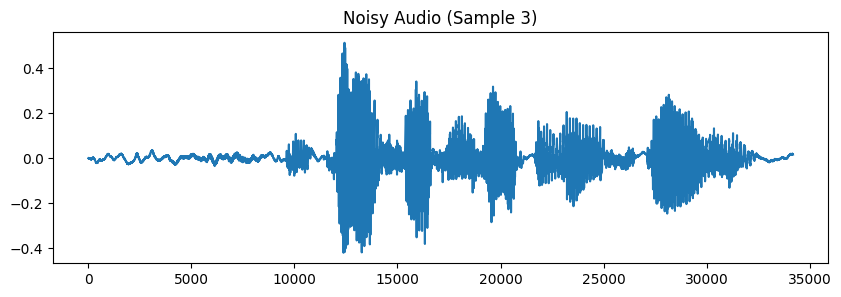

Noisy Audio:


Clean audio: 34198 samples, 2.14 seconds, 16000 Hz


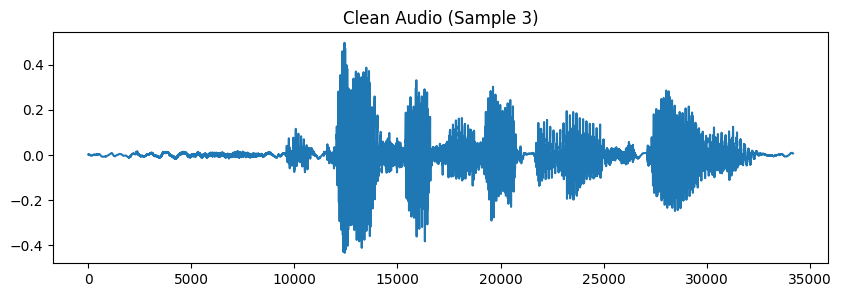

Clean Audio:


In [2]:
# Add a cell to examine and listen to examples from the full_ds
from IPython.display import Audio, display
import matplotlib.pyplot as plt
import numpy as np

def examine_audio_samples(dataset, num_samples=2):
    """
    Examine and listen to random samples from a dataset.
    """
    # Get random indices to sample from different parts of the dataset
    total_samples = len(dataset)
    
    # Try to get samples from different parts of the dataset
    # (likely from custom, train, and test portions)
    sample_indices = [
        np.random.randint(0, min(1000, total_samples//3)),  # First third (likely custom data)
        np.random.randint(total_samples//3, 2*total_samples//3),  # Middle third (likely train data)
        np.random.randint(2*total_samples//3, total_samples)  # Last third (likely test data)
    ][:num_samples]
    
    for i, idx in enumerate(sample_indices):
        sample = dataset[idx]
        
        print(f"\n--- Sample {i+1} (Index {idx}) ---")
        print(f"ID: {sample['id']}")
        
        # Display and play noisy audio
        if "noisy" in sample:
            noisy_audio = sample["noisy"]["array"]
            sr = sample["noisy"]["sampling_rate"]
            duration = len(noisy_audio)/sr
            print(f"Noisy audio: {len(noisy_audio)} samples, {duration:.2f} seconds, {sr} Hz")
            
            # Plot waveform
            plt.figure(figsize=(10, 3))
            plt.plot(noisy_audio)
            plt.title(f"Noisy Audio (Sample {i+1})")
            plt.show()
            
            # Play audio
            print("Noisy Audio:")
            display(Audio(noisy_audio, rate=sr))
        
        # Display and play clean audio
        if "clean" in sample:
            clean_audio = sample["clean"]["array"]
            sr = sample["clean"]["sampling_rate"]
            duration = len(clean_audio)/sr
            print(f"Clean audio: {len(clean_audio)} samples, {duration:.2f} seconds, {sr} Hz")
            
            # Plot waveform
            plt.figure(figsize=(10, 3))
            plt.plot(clean_audio)
            plt.title(f"Clean Audio (Sample {i+1})")
            plt.show()
            
            # Play audio
            print("Clean Audio:")
            display(Audio(clean_audio, rate=sr))

examine_audio_samples(full_ds, num_samples=3)

In [3]:
from mydatasets.rawAudioDenoisingDataset import RawAudioDenoisingDataset

train_ds,test_ds = full_ds.train_test_split(test_size=0.2).values()
train_ds,val_ds = train_ds.train_test_split(test_size=0.25).values()

# Set a fixed length for training (e.g., 2 seconds of audio at 16kHz = 32000 samples)
# Or set to None to keep variable length with padding in batches
fixed_length = None  # 32000  # Use a fixed length like this, or None for variable length

# Create datasets
train_dataset = RawAudioDenoisingDataset(train_ds, fixed_length=fixed_length, augment=True)
val_dataset = RawAudioDenoisingDataset(val_ds, fixed_length=fixed_length)
test_dataset = RawAudioDenoisingDataset(test_ds, fixed_length=fixed_length)

# Create data loaders
batch_size = 10
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True,
    collate_fn=RawAudioDenoisingDataset.variable_length_collate if fixed_length is None else None
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    collate_fn=RawAudioDenoisingDataset.variable_length_collate if fixed_length is None else None
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    collate_fn=RawAudioDenoisingDataset.variable_length_collate if fixed_length is None else None
)

# Verify a batch
for batch in train_loader:
    print(f"Noisy audio shape: {batch['noisy'].shape}")
    print(f"Clean audio shape: {batch['clean'].shape}")
    if fixed_length is None:
        print(f"Sequence lengths: {batch['lengths']}")
    break

Noisy audio shape: torch.Size([10, 60212])
Clean audio shape: torch.Size([10, 60212])
Sequence lengths: tensor([60212, 37016, 29717, 40160, 31429, 32860, 32670, 45014, 45297, 29834])


In [4]:
from models.myModel.my_model import InceptionFCN
from models.waveUNet.waveunet import Waveunet
from torch import nn
import torch.multiprocessing as mp
from training.ddp_trainer import run_ddp_training


In [5]:
import torch
#Allowing loading any model architecture
# Test with a sample batch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Create and initialize the model

#model = InceptionFCN(residual_learning=True).to(device)

model = Waveunet(
    num_inputs=1,                    # Mono speech is common
    num_channels=[32, 64, 128, 256, 512, 1024],  # 6 levels with doubling features
    num_outputs=1,                   # Output clean speech
    instruments=["speech"],          # Single target
    kernel_size=15,                  # Larger kernel for better frequency resolution
    conv_type="gn",                  # Group normalization
    res="fixed",                     # Fixed resampling (better for speech)
    separate=False,                  # Using shared model
    depth=1,                         # Standard depth
    strides=2                        # Smaller strides to preserve speech details
).to(device)



# Get a sample batch
for batch in train_loader:
    noisy = batch['noisy'].unsqueeze(1).to(device)
    print(noisy.shape)
    clean = batch['clean'].unsqueeze(1).to(device)
    # Forward pass
    output = model(noisy)

    
    print(f"Input shape: {noisy.shape}")
    print(f"Output shape: {output.shape}")
    print(f"Target shape: {clean.shape}")
    break

# Setup loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

torch.Size([10, 1, 122240])
Input shape: torch.Size([10, 1, 122240])
Output shape: torch.Size([10, 1, 122240])
Target shape: torch.Size([10, 1, 122240])


In [6]:
# Determine which method to use
world_size = torch.cuda.device_count()
print(f"Number of available GPUs: {world_size}")
num_epochs = 7

if world_size > 1:
    # Run DDP training from the external module
    print("Starting distributed training...")
    

    mp.set_start_method('spawn', force=True)
    
    best_model_path = run_ddp_training(
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        batch_size=batch_size,
        fixed_length=fixed_length,
        variable_length_collate=RawAudioDenoisingDataset.variable_length_collate,
        num_epochs=num_epochs
    )
    

# Save the final model
model_path = "../checkpoints/denoising_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Number of available GPUs: 6
Starting distributed training...


[rank0]:[W410 06:51:03.910950434 ProcessGroupNCCL.cpp:1496] Warning: WARNING: destroy_process_group() was not called before program exit, which can leak resources. For more info, please see https://pytorch.org/docs/stable/distributed.html#shutdown (function operator())
W0410 06:51:04.984000 2700660 site-packages/torch/multiprocessing/spawn.py:169] Terminating process 2700970 via signal SIGTERM
W0410 06:51:04.987000 2700660 site-packages/torch/multiprocessing/spawn.py:169] Terminating process 2701043 via signal SIGTERM
W0410 06:51:04.990000 2700660 site-packages/torch/multiprocessing/spawn.py:169] Terminating process 2701119 via signal SIGTERM
W0410 06:51:04.993000 2700660 site-packages/torch/multiprocessing/spawn.py:169] Terminating process 2701205 via signal SIGTERM
W0410 06:51:04.995000 2700660 site-packages/torch/multiprocessing/spawn.py:169] Terminating process 2701283 via signal SIGTERM


ProcessRaisedException: 

-- Process 0 terminated with the following error:
Traceback (most recent call last):
  File "/home/hkngae/anaconda3/envs/COMP5412/lib/python3.11/site-packages/torch/multiprocessing/spawn.py", line 90, in _wrap
    fn(i, *args)
  File "/home/hkngae/COMP5412/training/ddp_trainer.py", line 76, in train_ddp
    output = model(noisy)
             ^^^^^^^^^^^^
  File "/home/hkngae/anaconda3/envs/COMP5412/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1739, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hkngae/anaconda3/envs/COMP5412/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1750, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hkngae/anaconda3/envs/COMP5412/lib/python3.11/site-packages/torch/nn/parallel/distributed.py", line 1643, in forward
    else self._run_ddp_forward(*inputs, **kwargs)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hkngae/anaconda3/envs/COMP5412/lib/python3.11/site-packages/torch/nn/parallel/distributed.py", line 1459, in _run_ddp_forward
    return self.module(*inputs, **kwargs)  # type: ignore[index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hkngae/anaconda3/envs/COMP5412/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1739, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hkngae/anaconda3/envs/COMP5412/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1750, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hkngae/COMP5412/models/waveUNet/waveunet.py", line 234, in forward
    out = self.forward_module(x, self.waveunets["ALL"])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hkngae/COMP5412/models/waveUNet/waveunet.py", line 208, in forward_module
    out = conv(out)
          ^^^^^^^^^
  File "/home/hkngae/anaconda3/envs/COMP5412/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1739, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hkngae/anaconda3/envs/COMP5412/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1750, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hkngae/COMP5412/models/waveUNet/conv.py", line 32, in forward
    out = F.relu(self.norm((self.filter(x))))
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hkngae/anaconda3/envs/COMP5412/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1739, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hkngae/anaconda3/envs/COMP5412/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1750, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hkngae/anaconda3/envs/COMP5412/lib/python3.11/site-packages/torch/nn/modules/normalization.py", line 313, in forward
    return F.group_norm(input, self.num_groups, self.weight, self.bias, self.eps)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hkngae/anaconda3/envs/COMP5412/lib/python3.11/site-packages/torch/nn/functional.py", line 2965, in group_norm
    return torch.group_norm(
           ^^^^^^^^^^^^^^^^^
torch.OutOfMemoryError: CUDA out of memory. Tried to allocate 158.00 MiB. GPU 0 has a total capacity of 23.59 GiB of which 15.19 MiB is free. Process 2700660 has 14.53 GiB memory in use. Including non-PyTorch memory, this process has 7.77 GiB memory in use. Process 2700970 has 254.00 MiB memory in use. Process 2701043 has 254.00 MiB memory in use. Process 2701119 has 254.00 MiB memory in use. Process 2701205 has 254.00 MiB memory in use. Process 2701283 has 254.00 MiB memory in use. Of the allocated memory 7.29 GiB is allocated by PyTorch, and 62.94 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Test Loss: 0.013113
Average SNR before denoising: 7.03 dB
Average SNR after denoising: -0.00 dB
Average SNR improvement: -7.03 dB


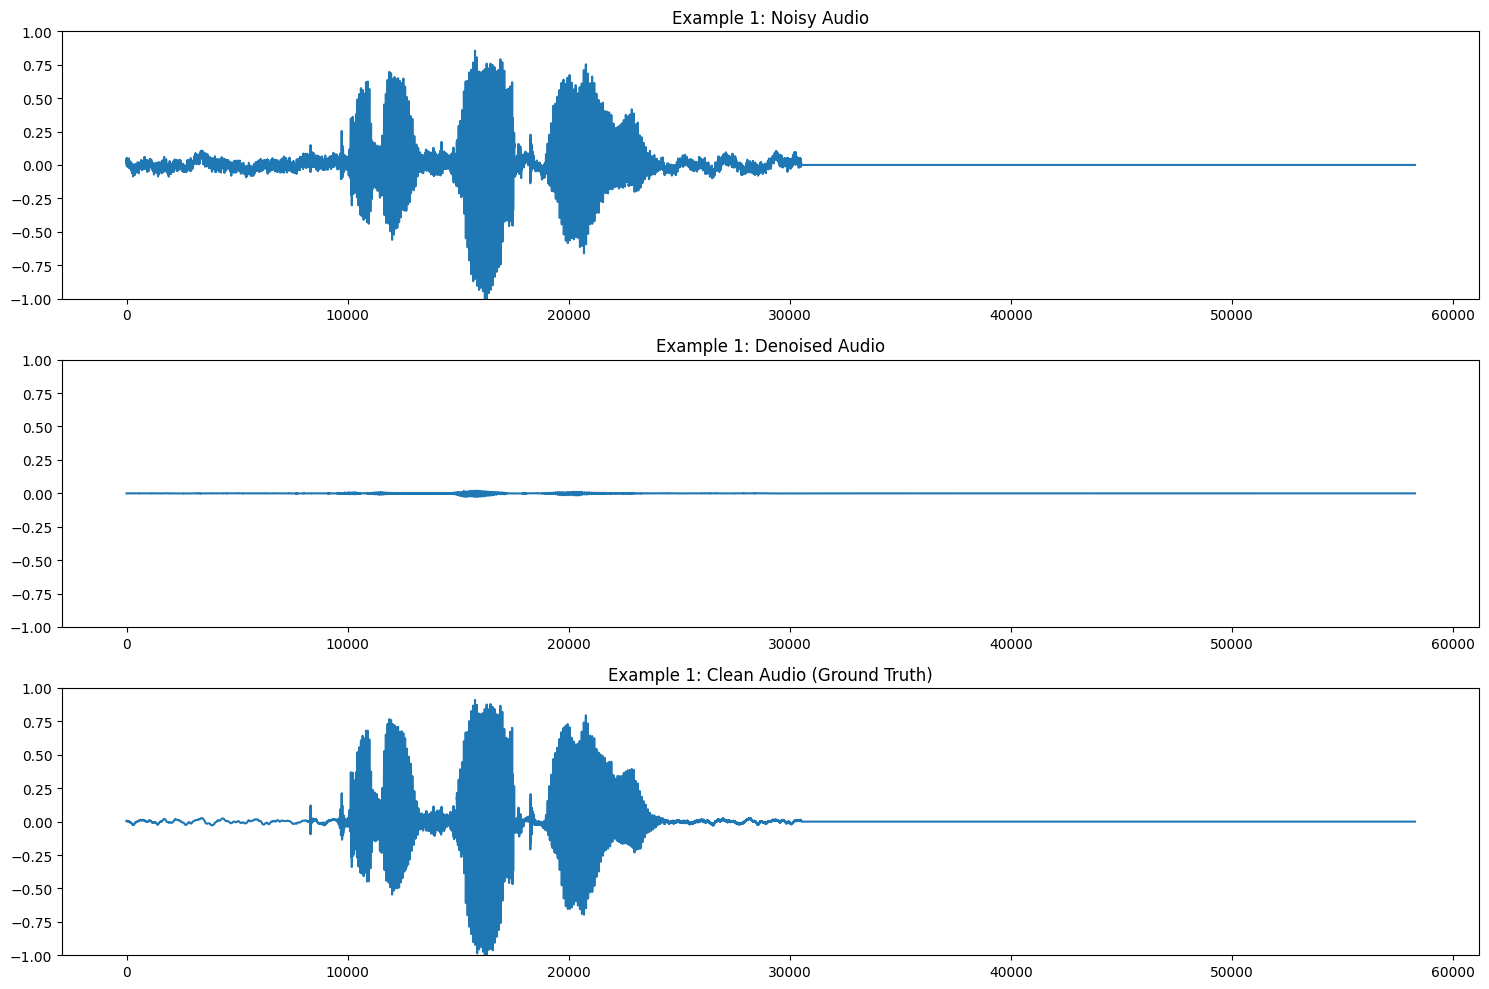


Example 1 - Audio playback:
Noisy Audio:


Denoised Audio:


Clean Audio (Ground Truth):


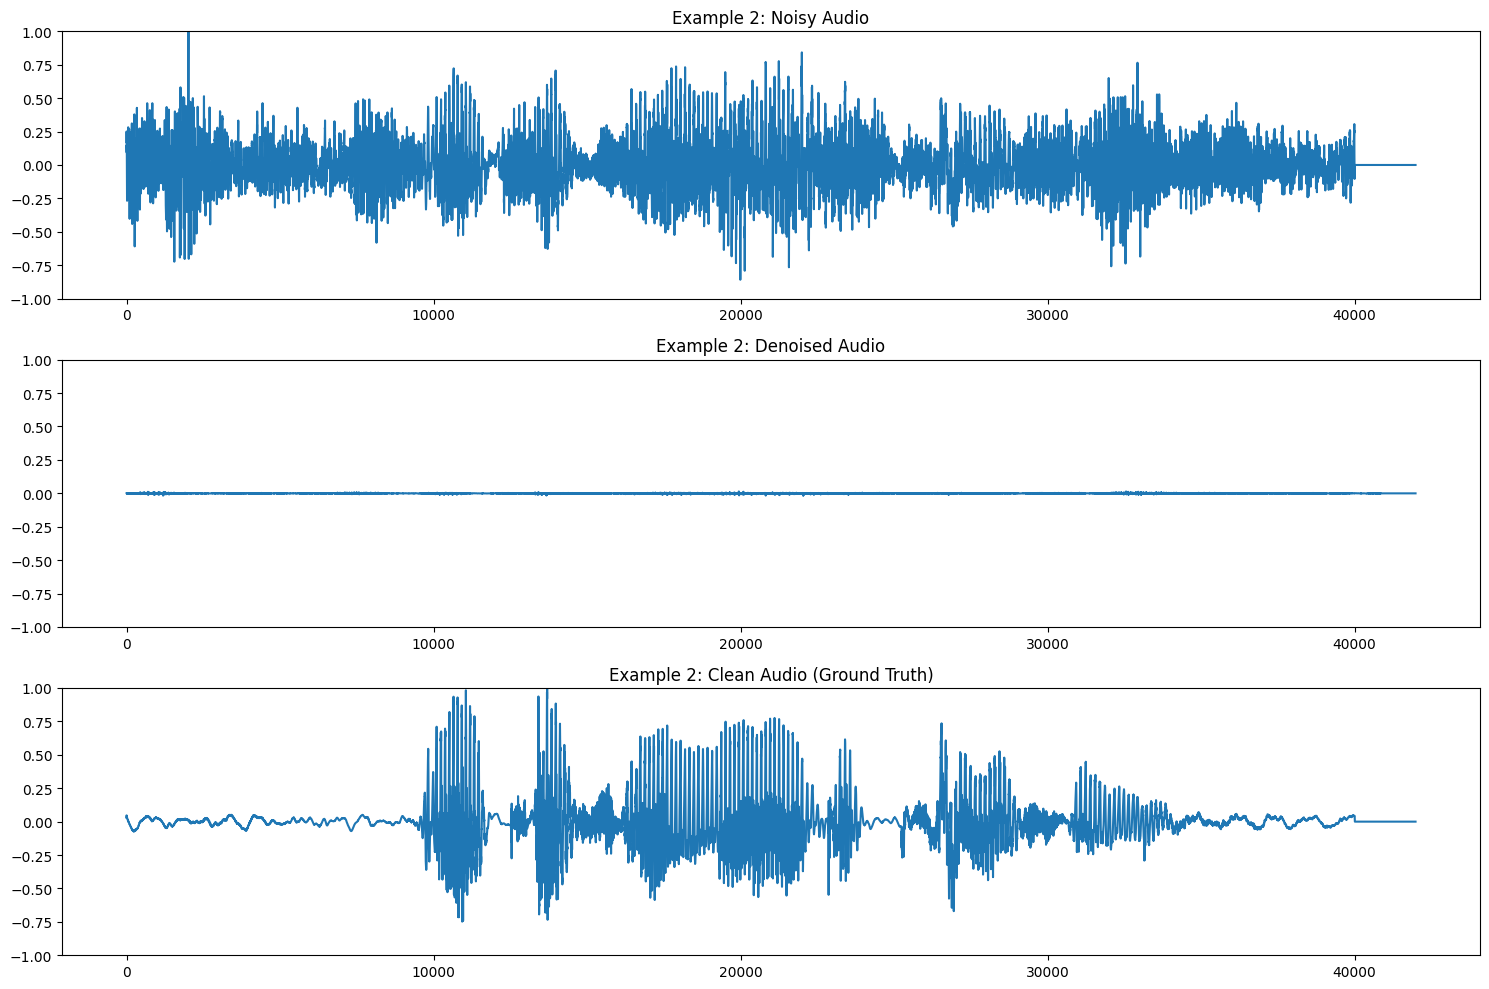


Example 2 - Audio playback:
Noisy Audio:


Denoised Audio:


Clean Audio (Ground Truth):


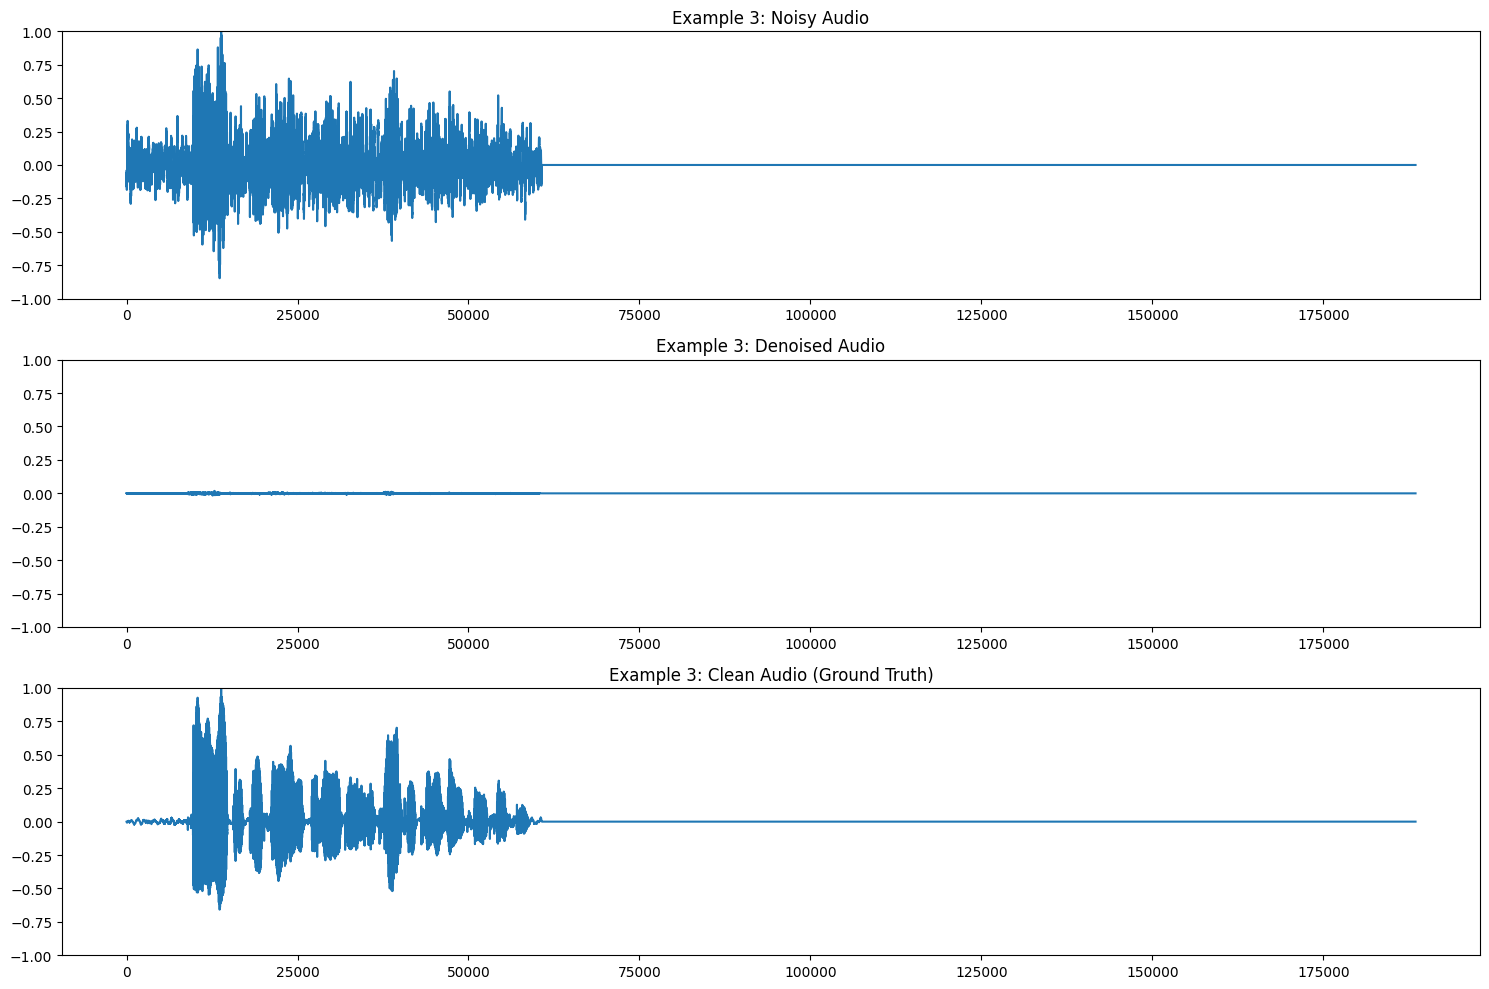


Example 3 - Audio playback:
Noisy Audio:


Denoised Audio:


Clean Audio (Ground Truth):


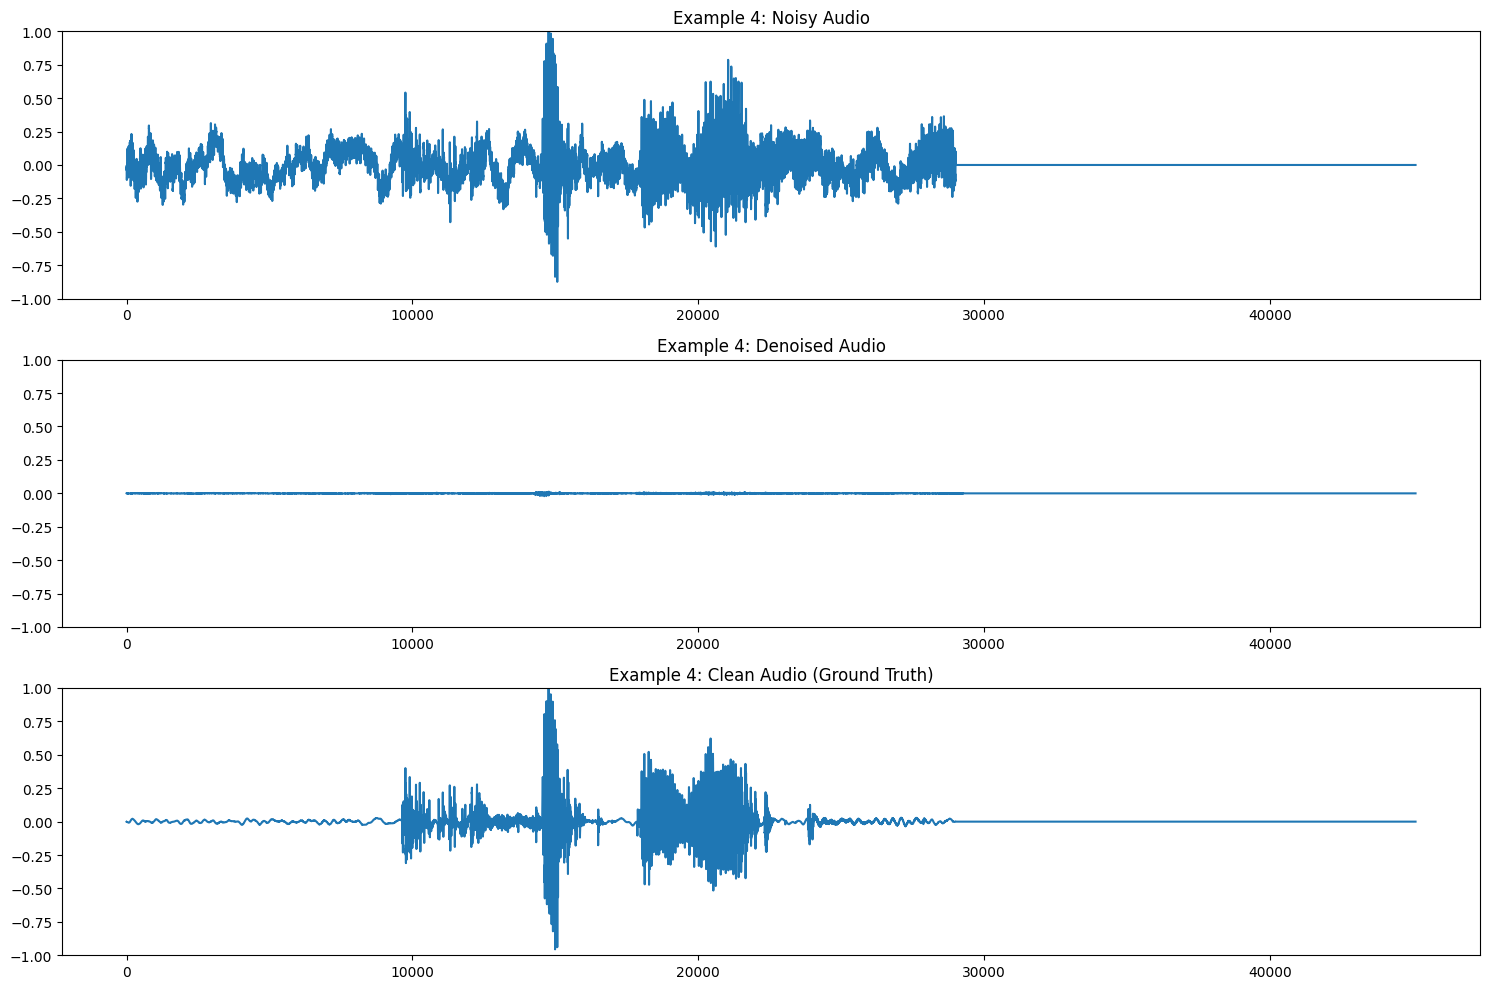


Example 4 - Audio playback:
Noisy Audio:


Denoised Audio:


Clean Audio (Ground Truth):


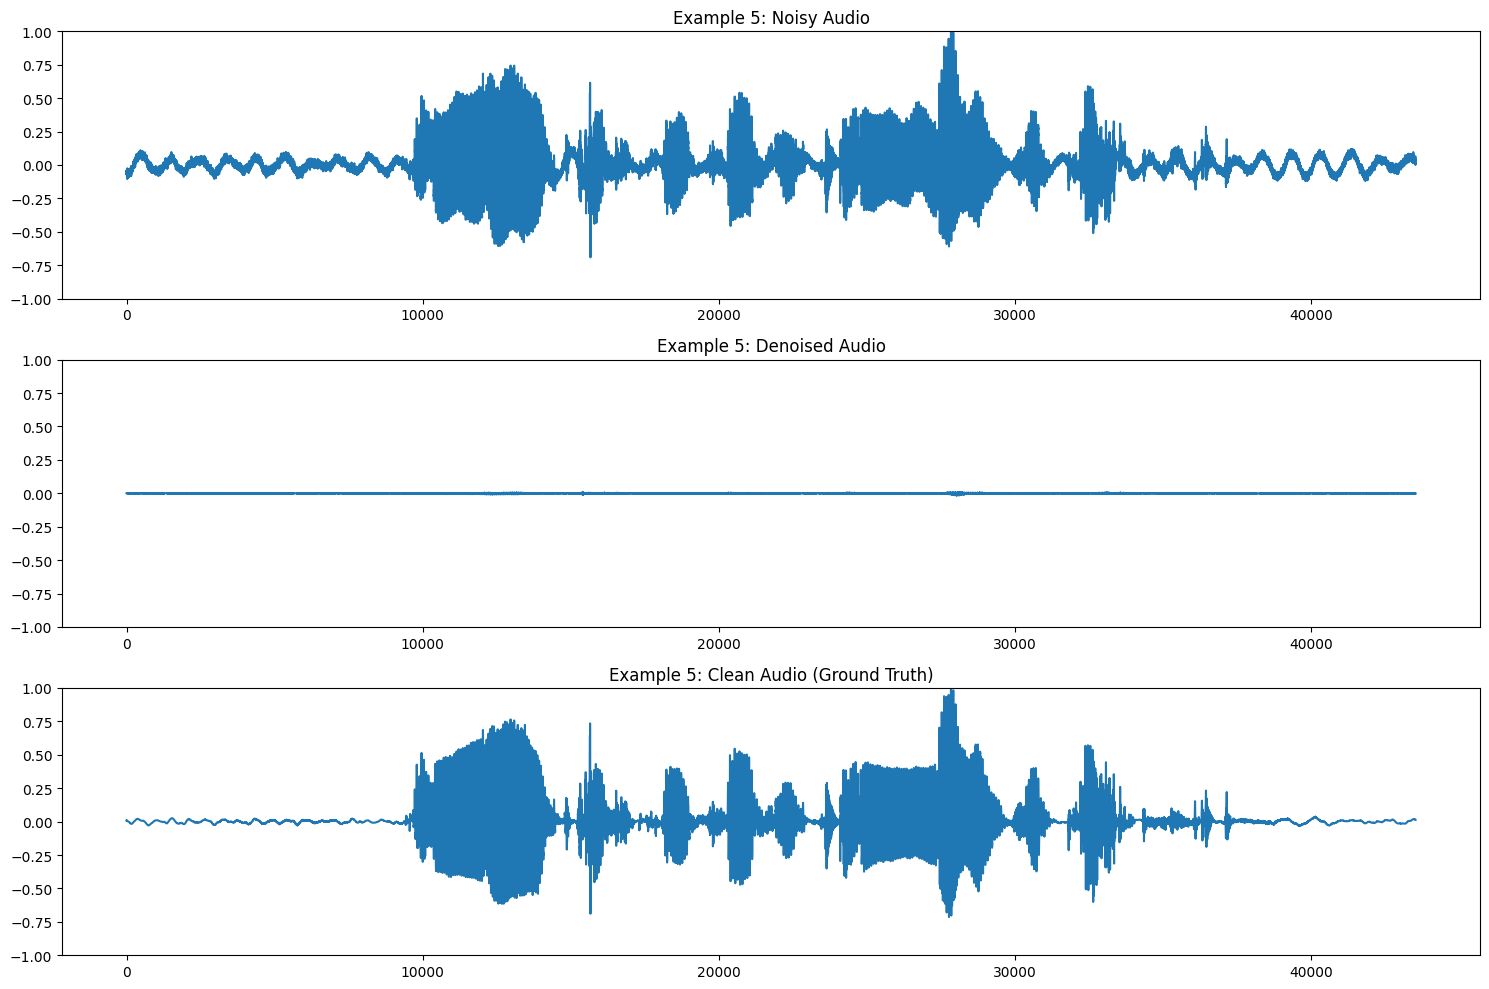


Example 5 - Audio playback:
Noisy Audio:


Denoised Audio:


Clean Audio (Ground Truth):


In [11]:
import numpy as np
import matplotlib.pyplot as plt
def test_model(model, test_loader, criterion=None, save_examples=True, num_examples=5):
    """
    Test the denoising model and compute metrics
    
    Args:
        model: The trained model
        test_loader: DataLoader for test data
        criterion: Loss function (optional)
        save_examples: Whether to save example denoised files
        num_examples: Number of examples to visualize and save
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    test_loss = 0.0
    all_snr_before = []
    all_snr_after = []
    examples = []
    
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            noisy = batch['noisy'].unsqueeze(1).to(device)  # Add channel dimension
            clean = batch['clean'].unsqueeze(1).to(device)  # Add channel dimension
            
            
            # Forward pass
            denoised = model(noisy)
            
            # Store some examples
            if i < num_examples:
                examples.append({
                    'noisy': noisy[0].cpu().numpy().flatten(),
                    'clean': clean[0].cpu().numpy().flatten(),
                    'denoised': denoised[0].cpu().numpy().flatten()
                })
            
            # Calculate metrics
            if criterion:
                loss = criterion(denoised, clean)
                test_loss += loss.item() * noisy.size(0)
            
            # Calculate SNR before and after denoising
            for j in range(noisy.size(0)):
                # Original SNR
                noise = noisy[j].cpu().numpy() - clean[j].cpu().numpy()
                signal_power = np.mean(clean[j].cpu().numpy() ** 2)
                noise_power = np.mean(noise ** 2)
                snr_before = 10 * np.log10(signal_power / noise_power) if noise_power > 0 else float('inf')
                
                # SNR after denoising
                noise_after = denoised[j].cpu().numpy() - clean[j].cpu().numpy()
                noise_power_after = np.mean(noise_after ** 2)
                snr_after = 10 * np.log10(signal_power / noise_power_after) if noise_power_after > 0 else float('inf')
                
                all_snr_before.append(snr_before)
                all_snr_after.append(snr_after)
    
    # Calculate average metrics
    if criterion:
        avg_loss = test_loss / len(test_loader.dataset)
        print(f'Test Loss: {avg_loss:.6f}')
    
    avg_snr_before = np.mean(all_snr_before)
    avg_snr_after = np.mean(all_snr_after)
    snr_improvement = avg_snr_after - avg_snr_before
    
    print(f'Average SNR before denoising: {avg_snr_before:.2f} dB')
    print(f'Average SNR after denoising: {avg_snr_after:.2f} dB')
    print(f'Average SNR improvement: {snr_improvement:.2f} dB')
    
    # Visualize examples
    for i, example in enumerate(examples):
        plt.figure(figsize=(15, 10))
        
        # Plot waveforms
        plt.subplot(3, 1, 1)
        plt.plot(example['noisy'])
        plt.title(f'Example {i+1}: Noisy Audio')
        plt.ylim(-1, 1)
        
        plt.subplot(3, 1, 2)
        plt.plot(example['denoised'])
        plt.title(f'Example {i+1}: Denoised Audio')
        plt.ylim(-1, 1)
        
        plt.subplot(3, 1, 3)
        plt.plot(example['clean'])
        plt.title(f'Example {i+1}: Clean Audio (Ground Truth)')
        plt.ylim(-1, 1)
        
        plt.tight_layout()
        plt.show()
        
        # Create audio players
        sr = 16000  # Assuming 16kHz sample rate
        print(f"\nExample {i+1} - Audio playback:")
        
        print("Noisy Audio:")
        display(Audio(example['noisy'], rate=sr))
        
        print("Denoised Audio:")
        display(Audio(example['denoised'], rate=sr))
        
        print("Clean Audio (Ground Truth):")
        display(Audio(example['clean'], rate=sr))


    return {
        'loss': avg_loss if criterion else None,
        'snr_before': avg_snr_before,
        'snr_after': avg_snr_after,
        'snr_improvement': snr_improvement,
        'examples': examples
    }

#load the best model
model.load_state_dict(torch.load('../checkpoints/best_model_ddp.pth'))
# Run the test
test_results = test_model(model, test_loader, criterion)